In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="0,1,2,3,4,5"
os.environ['OMP_NUM_THREADS']="4"
os.environ['NUMBA_NUM_THREADS']="4"
os.environ['MKL_NUM_THREADS']="4"

In [2]:
%load_ext autoreload
%autoreload 2 
import pandas as pd; import anndata; import numpy as np; import gzip; import io; import h5py
import collections; import matplotlib.pyplot as plt; import time; import sys; import tqdm.notebook
import pickle; import scipy as sp; import scipy.sparse; import scipy.stats; rng=np.random.default_rng()
import PIL; PIL.Image.MAX_IMAGE_PIXELS = None; import matplotlib
%matplotlib inline
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
    "text.usetex": True,
})
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [3]:
import sklearn.neighbors
import torch_geometric
import pytorch_lightning as pl
import torch
import os
import shutil

# load

In [4]:
def process(fn):
    with h5py.File(fn,'r') as f:
        dct={}
        for x in ['Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Cell_ID', 'Cell_class', 
                  'Centroid_X', 'Centroid_Y', 'Neuron_cluster_ID']:
            dct[x]=f[x][:]
            if dct[x].dtype.kind=='S':
                dct[x]=dct[x].astype("U")
        for x in ['Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Cell_class', 'Neuron_cluster_ID']:
            dct[x]=pd.Categorical(dct[x])
        X=f['expression'][:]
        var=pd.DataFrame(index=f['gene_names'][:].astype('U'))
    ad=anndata.AnnData(X=X,var=var,obs=pd.DataFrame(data=dct),dtype=np.float32) # <-- stored as float16 (!)
    ad.obs['tissue_id']=pd.Categorical(ad.obs.Animal_ID.astype(str).str.cat(ad.obs.Bregma.astype(str),sep='_'))
   
    dct=collections.defaultdict(list)
    for x in ad.obs.tissue_id.cat.categories:
        idx=np.where(ad.obs.tissue_id==x)[0][0]
        for nm in ['Animal_ID','Animal_sex','Behavior','Bregma']:
            dct[nm].append(ad.obs.iloc[idx][nm])
        dct['tissue_id'].append(x)
    df=pd.DataFrame(dct,index=dct['tissue_id'])
    df['split']=np.where(df['Animal_ID'].values>30,'test','train')
    ad.uns['tissueinfo']=df

    return ad

In [5]:
basefn='/data/spatial/deepst_synthetic/'
ad=process(basefn+"synth0.hdf5")

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# construct edges

In [6]:
radius=30
loc=ad.obs[['Centroid_X','Centroid_Y']].values
rows=[]
cols=[]
for nm in tqdm.notebook.tqdm(ad.obs.tissue_id.cat.categories):
    indicator=ad.obs.tissue_id==nm
    adjacency=sklearn.neighbors.radius_neighbors_graph(loc[indicator],radius).tocoo()
    rows.extend(np.where(indicator)[0][adjacency.row])
    cols.extend(np.where(indicator)[0][adjacency.col])
adjacency=sp.sparse.coo_matrix((np.ones(len(rows)),(rows,cols)),shape=(len(ad),len(ad))).tocsr()

  0%|          | 0/181 [00:00<?, ?it/s]

In [7]:
with h5py.File("../data/raw/synth0.hdf5", "r") as h5f:
    print("EXPRESSION AFTER")
    expression = h5f["expression"][:]
    print(type(expression[0,0]))

EXPRESSION AFTER
<class 'numpy.float64'>


In [8]:
print(type(ad.X[0,0]))

<class 'numpy.float32'>


In [9]:
ad.X, expression

(array([[1.4, 0.2, 0.2, ..., 0. , 0. , 0. ],
        [1.4, 1. , 0. , ..., 0.2, 0. , 0.6],
        [1.8, 0.2, 0.4, ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0.2, 0.2, 0.2],
        [0. , 0.2, 0. , ..., 0.4, 0.2, 0.4],
        [0. , 0.6, 0. , ..., 0. , 0. , 0.2]], dtype=float32),
 array([[0.        , 0.2       , 0.2       , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.        , ..., 0.2       , 0.        ,
         0.60000002],
        [0.        , 0.2       , 0.40000001, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.20000002, 0.        , 0.        , ..., 0.2       , 0.2       ,
         0.2       ],
        [0.        , 0.2       , 0.        , ..., 0.40000001, 0.2       ,
         0.40000001],
        [0.        , 0.60000002, 0.        , ..., 0.        , 0.        ,
         0.2       ]]))

In [10]:
X1sum=(adjacency@expression[:,1]+expression[:,1])
X0=expression[:,0]

print("MSE",np.mean((np.where(X1sum>1,X1sum,0)-X0)**2))
print("MSE",np.mean((np.where(X1sum>=1,X1sum,0)-X0)**2))
print("MSE",np.mean((np.where(X1sum>.997,X1sum,0)-X0)**2))

MSE 1.4702713334530477
MSE 1.4693492125775733
MSE 1.4693492125775733


In [11]:
ad.X[0]

array([1.4, 0.2, 0.2, 0.4, 0.4, 0. , 0.4, 0. , 0.4, 0. , 0. , 0. , 0. ,
       0. , 1. , 0.2, 0. , 0. , 0.4, 0. , 0. , 0.2, 0. , 0. , 0.4, 0. ,
       0.6, 0. , 0.2, 0.2, 0.6, 0.4, 0. , 0. , 0. , 0.2, 0. , 0.4, 0. ,
       0. , 0. , 0.4, 0.2, 0. , 0. , 0.2, 0. , 0. , 0.4, 0. , 0.2, 0.2,
       0. , 0. , 0.2, 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0.2, 0. , 0. ,
       0.4, 0.4, 0.4, 0. , 0.2, 0.2, 0. , 0. , 0. , 0. , 0.4, 0.2, 0.4,
       0. , 0. , 0.6, 0.8, 0.2, 0.2, 0.8, 0. , 0.2, 0.6, 0. , 1.2, 0. ,
       0.2, 0. , 0. , 0.2, 0. , 0. , 0.2, 0.2, 0. , 0.2, 0.6, 0.4, 0.2,
       0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0.2, 0. , 0.2, 0. , 0. ,
       0. , 1. , 0.2, 0.4, 0. , 0. , 0. , 0.2, 0. , 0. , 1.2, 0.2, 0. ,
       0. , 0. , 0.4, 0. , 0. , 0. , 0.4, 0. , 0.6, 0. , 0. , 0.6, 0.2,
       0. , 0.2, 0.2, 0. , 0. , 0.6, 0.2, 0. , 0. , 0.4, 0.2, 0.2, 0.2,
       0. , 0. , 0. , 0. , 0. ], dtype=float32)

Text(0, 0.5, 'What X0 actually is')

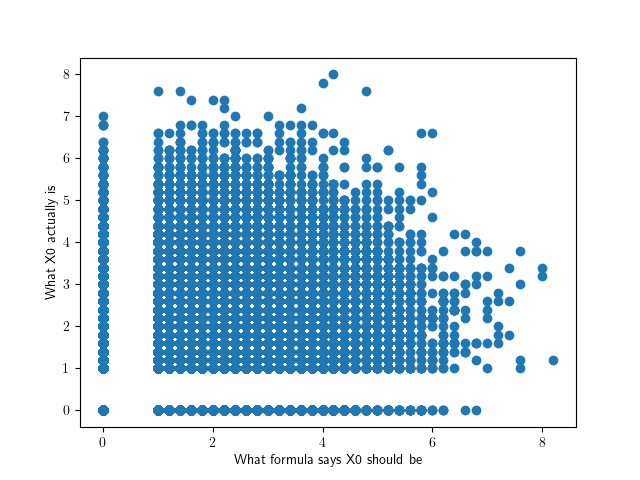

In [12]:
plt.scatter(np.where(X1sum>1,X1sum,0),X0)
plt.xlabel("What formula says X0 should be")
plt.ylabel("What X0 actually is")

# construct nefarious edges

In [13]:
radius=60 # oh noes, I got the radius wrong!
loc=ad.obs[['Centroid_X','Centroid_Y']].values
rows=[]
cols=[]
for nm in tqdm.notebook.tqdm(ad.obs.tissue_id.cat.categories):
    indicator=ad.obs.tissue_id==nm
    adjacency=sklearn.neighbors.radius_neighbors_graph(loc[indicator],radius).tocoo()
    rows.extend(np.where(indicator)[0][adjacency.row])
    cols.extend(np.where(indicator)[0][adjacency.col])
nefarious_adjacency=sp.sparse.coo_matrix((np.ones(len(rows)),(rows,cols)),shape=(len(ad),len(ad))).tocsr()

  0%|          | 0/181 [00:00<?, ?it/s]

# formulate dataset for use with pytorch geometric

In [14]:
def calc_pseudo(edge_index, pos):
    coord1 = pos[edge_index[0]]
    coord2 = pos[edge_index[1]]
    edge_dir = coord2 - coord1
    rho = torch.sqrt(edge_dir[:, 0] ** 2 + edge_dir[:, 1] ** 2).unsqueeze(-1)
    return rho

X=ad.X[:,1:]
Y=ad.X[:,[0]]
loc=ad.obs[['Centroid_X','Centroid_Y']].values

datalist_train=[]
datalist_test=[]
for tid in tqdm.notebook.tqdm(ad.obs.tissue_id.cat.categories):
    indicator=ad.obs.tissue_id==tid
    subadj=nefarious_adjacency[indicator][:,indicator].tocoo()
    subpos= torch.tensor(loc[indicator].astype(np.float32))
    ei=torch.tensor(np.stack([subadj.row,subadj.col]).astype(int))
    pseudo=calc_pseudo(ei,subpos)#/30.0 # between 0 and 1, since only considering neighbors within radius 30
    batch=torch_geometric.data.Data(
        x=torch.tensor(np.log1p(X[indicator])),
        y=torch.tensor(np.log1p(Y[indicator])),
        edge_index=ei,
        edge_attr=pseudo,
    )
    if ad.uns['tissueinfo'].loc[tid].Animal_ID>30:
        datalist_test.append(batch)
    else:
        datalist_train.append(batch)
    

dl_train=torch_geometric.loader.DataLoader(datalist_train,shuffle=True)
dl_test=torch_geometric.loader.DataLoader(datalist_test)

  0%|          | 0/181 [00:00<?, ?it/s]

# try to learn with GMMconv

In [15]:
class DenseReluGMMConvNetwork(torch.nn.Module):
    def __init__(
        self,
        sizes,
        edge_dim,
        n_kernels,
        **gmmargs
    ):
        super().__init__()

        lst = []
        for i in range(len(sizes) - 1):
            gmmc = torch_geometric.nn.GMMConv(
                sizes[i], sizes[i + 1], dim=edge_dim,kernel_size=n_kernels)
            lst.append(gmmc)
            
        self.gmms = torch.nn.ModuleList(lst)

    def forward(self, vals, edges, pseudo):
        orig_vals = vals
        for i, gmmlayer in enumerate(self.gmms):
            vals = gmmlayer(vals, edges, pseudo)
            
            if (i != len(self.gmms) - 1):
                vals = torch.relu(vals)

        return vals

class MSEPredictor(pl.LightningModule):
    def __init__(self,n,lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.net=DenseReluGMMConvNetwork([n,512,512,512,1],edge_dim=1,n_kernels=10)
        
    def calc_lossinfo(self,batch):
        guess=self.net(batch.x,batch.edge_index,batch.edge_attr)
        loss=torch.mean((guess-batch.y)**2)
        return dict(
            loss=loss
        )
        
    def training_step(self, batch, batch_idx):
        info=self.calc_lossinfo(batch)
        self.log('train_loss',info['loss'],prog_bar=True,batch_size=1)
        return info['loss']
    
    def validation_step(self, batch, batch_idx):
        info=self.calc_lossinfo(batch)
        self.log('val_loss',info['loss'],prog_bar=True,batch_size=1)
        return info['loss']
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

In [16]:
torch.cuda.empty_cache()

In [17]:
if os.path.exists('lightning_logs/version_0'):
    shutil.rmtree('lightning_logs/version_0')

logger=pl.loggers.CSVLogger('.',version=0)
trainer = pl.Trainer(
    max_epochs=10,accelerator='gpu',
    devices=[0],logger=logger,log_every_n_steps=1,
)

model=MSEPredictor(ad.shape[1]-1)

trainer.fit(model,train_dataloaders=dl_train,val_dataloaders=dl_test)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name | Type                    | Params
-------------------------------------------------
0 | net  | DenseReluGMMConvNetwork | 6.7 M 
-------------------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.702    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.57 GiB (GPU 0; 10.75 GiB total capacity; 7.94 GiB already allocated; 1.95 GiB free; 8.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
df=pd.read_csv('lightning_logs/version_0/metrics.csv')
n=len(df)

plt.subplot(1,2,1)
plt.plot(df['train_loss'].dropna().index,df['train_loss'].dropna(),'.')
plt.plot(df['val_loss'].dropna().index,df['val_loss'].dropna(),'rx')

plt.subplot(1,2,2)
df2=df.iloc[n//2:]
plt.plot(df2['train_loss'].dropna().index,df2['train_loss'].dropna(),'.')
plt.plot(df2['val_loss'].dropna().index,df2['val_loss'].dropna(),'rx')

# plt.xlim(250,None)
# plt.ylim(1e6,1.5e6)

$\uparrow$ that's not converged.  Needs more epochs.  But anyway, it doesn't run out of RAM.

In [ ]:
# get final losses for each validation tissue
losses=[]
for batch in tqdm.notebook.tqdm(dl_test):
    losses.append(float(model.calc_lossinfo(batch)['loss'].detach().cpu().numpy()) )

In [ ]:
print(np.array(losses).round(3))

In [ ]:
# plot kernels at each layer
xs=np.r_[0:1:100j]
for i,gmm in enumerate(model.net.gmms):
    plt.subplot(3,2,i+1)
    for mu,sig in zip(gmm.mu.detach().cpu().numpy().ravel(),gmm.sigma.detach().cpu().numpy().ravel()):
        sig=np.abs(sig)
        plt.plot(xs,sp.stats.norm.pdf(xs,loc=mu,scale=sig),color='black')